In [1]:
from duration_processor import load_quiz_data
folder = '/Users/shiyihe/Desktop/USABILITY_ANALYSIS/tabular'
all_data = load_quiz_data(folder, ignore_completed=True)

## writing basic 

Correct answer length: 252
  format  avg_duration_sec  avg_similarity  avg_answer_length
0  hjson        392.978000        0.867446         254.777778
1   json        214.726111        0.978781         258.333333
2  json5        466.342250        0.746504         273.125000
3  jsonc        294.419455        0.972738         266.636364
4   toml        240.884636        0.946993         243.636364
5    xml        277.588143        0.911417         258.142857
6   yaml        373.655750        0.901956         266.916667


/var/folders/hs/htjkkv116fv94g1llc3jj8jc0000gn/T/ipykernel_3782/1501161786.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


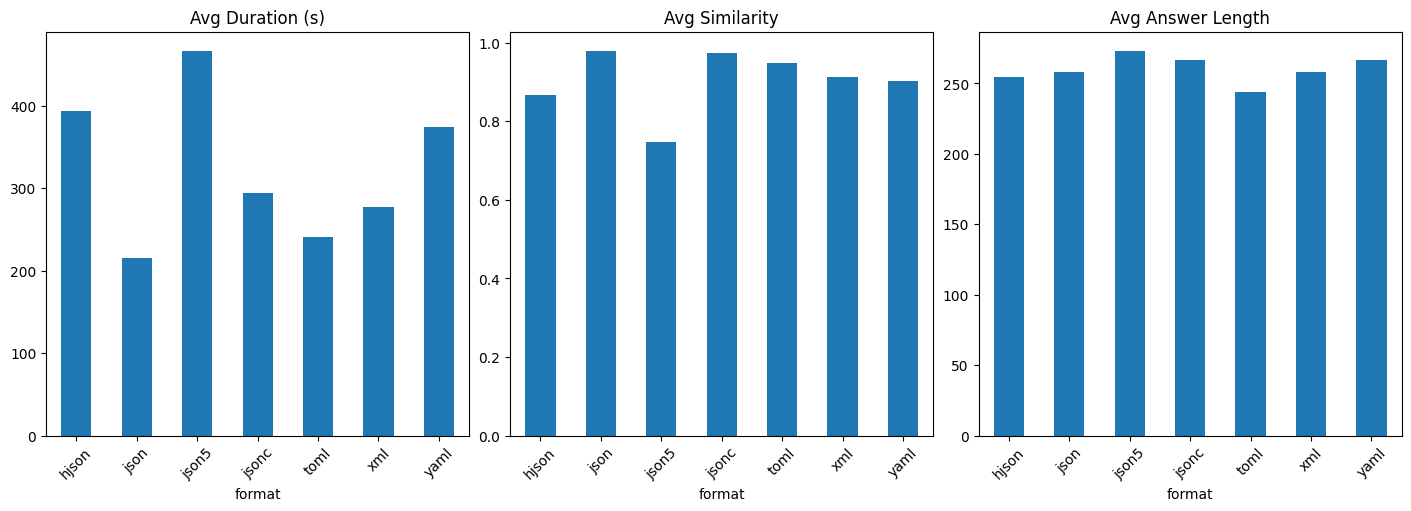

In [2]:
from writing_evaluator import (
    extract_writing_tasks,
    add_writing_metrics,
    get_correct_answer_length,
    summarize_writing_by_format,
    plot_writing_summary,
    extract_writing_tabular_tasks,
    plot_tabular_metrics_by_format
    # validate_tabular_syntax，
    # validate_strict_and_loose_syntax,
)

df_writing = extract_writing_tasks(all_data)

# 2. 定义正确答案
correct = (
    '"My life is very monotonous," the fox said. '
    '"I hunt chickens; men hunt me. All the chickens are just alike, '
    'and all the men are just alike. And, in consequence, '
    'I am a little bored. But if you tame me, '
    'it will be as if the sun came to shine on my life.'
)

# 3. 添加相似度和长度
df2 = add_writing_metrics(df_writing, correct)

# 4. 计算正确答案长度
correct_len = get_correct_answer_length(correct)
print("Correct answer length:", correct_len)

# 5. 汇总并可视化
summary = summarize_writing_by_format(df2)
print(summary)

fig = plot_writing_summary(summary)
fig.show()


Summary by format:
  format  avg_duration_sec  avg_help_clicks
0  hjson        700.130333         1.777778
1   json        711.858889         3.888889
2    xml        937.441571         1.000000


/var/folders/hs/htjkkv116fv94g1llc3jj8jc0000gn/T/ipykernel_3782/2115013860.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_dur.show()
/var/folders/hs/htjkkv116fv94g1llc3jj8jc0000gn/T/ipykernel_3782/2115013860.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_help.show()


,participantId,format,code,startTime,endTime,duration_sec,helpButtonClickedCount
0,6697c8b6d9d7baa7edd8c4d3,hjson,patients: [\n {\n name: John\n ...,1745932567200,1745933142854,575.654,0
1,66475d6f7b27e4443ef0d031,json,{\n patients\n if(name)=John\n then{\...,1744921480385,1744921734203,253.818,0
2,67e571bef6af7ecd9c29ad72,json,"{\n ""patients"" : [\n {\n ""name""...",1746146822874,1746147358937,536.063,0
3,60f1f1d4ac991a259b83f603,json,Note: Different colors represent different lev...,1746232143082,1746232546737,403.655,0
4,678f0bb28ec3307e4f1afb78,hjson,{patient\n name: John\n tests: \n ...,1746145002506,1746145881479,878.973,6
5,669b961e1c9cf30a26bb57d2,xml,<patients>\n <patient>\n <name>John<...,1746232263758,1746232658791,395.033,0
6,673c13c9d37c8a73bc80b8ce,json,"{\n ""patient"" : {\n ""name"" : ""John"",...",1746145824604,1746146954586,1129.982,0
7,60721c2da01b3a616edba9a7,xml,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<hopit...",1745930803789,1745931968128,1164.339,0
8,66cdfebcb908ea2717d06b6c,hjson,Patients: [\n {\n name: John\n tests:...,1746144340538,1746144857279,516.741,1
9,67d95269b47464c18da766ca,xml,"<person id=""101>patients\n<name>John</name>\n<...",1746150481726,1746151603170,1121.444,1


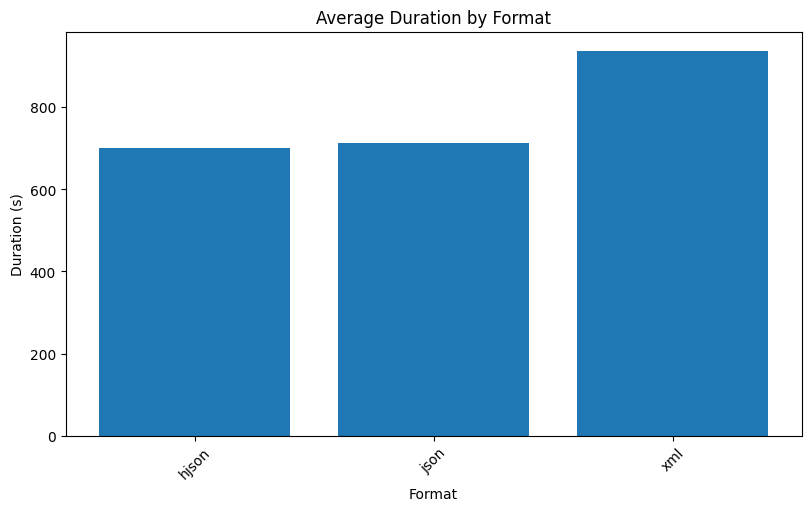

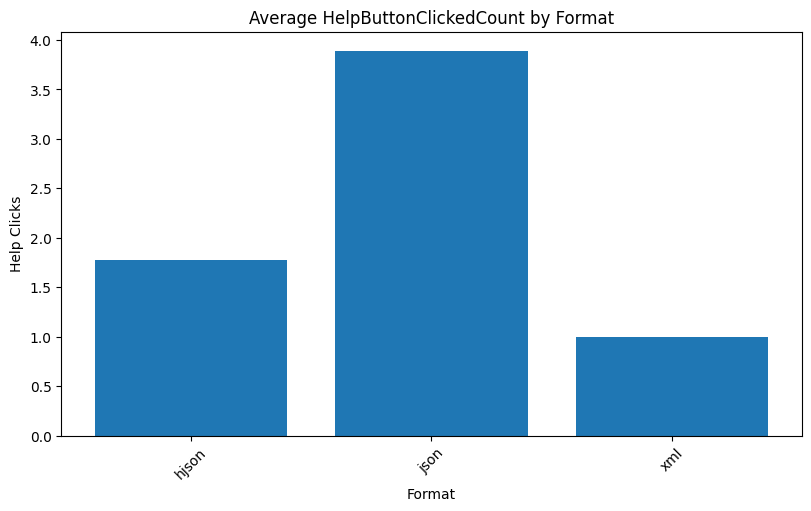

In [3]:
df_tabular = extract_writing_tabular_tasks(all_data, format_list=['hjson','json','xml'])
fig_dur, fig_help = plot_tabular_metrics_by_format(
    df_tabular,
    format_list=['hjson','json','xml']
)
fig_dur.show()
fig_help.show()
df_tabular.head(10)

## syntax check

In [2]:
from linter import plot_similarity_score_by_format, plot_avg_total_changes_by_format, plot_syntax_pass_rates, analyze_tabular_writing_diff,batch_tree_distance_analysis, validate_tabular_syntax_all, summarize_syntax_pass_rates # 假设文件名就是 writing_tabular_analysis.py

from writing_evaluator import extract_writing_tabular_tasks
# —————————————————————————————————————————————
# 3. 方法一：简单严格语法校验
# —————————————————————————————————————————————
df_tab       = extract_writing_tabular_tasks(all_data)
df_checked = validate_tabular_syntax_all(
    df_tab,
    code_col='code',
    format_col='format',
    strict_col='syntax_strict',
    loose_col='syntax_loose',
    repair_col='syntax_repair'
)

print(df_checked.head())

summary_df = summarize_syntax_pass_rates(df_checked)
print(summary_df)

              participantId format  \
0  6697c8b6d9d7baa7edd8c4d3  hjson   
1  67e25388d573ec2d5f1c8442   yaml   
2  67e5cf90b79d0874e1cf16b0   toml   
3  67d00f24466a67ba7e41228e   toml   
4  66475d6f7b27e4443ef0d031   json   

                                                code      startTime  \
0  patients: [\n    {\n        name: John\n      ...  1745932567200   
1  person:\n  name: John\ntests\n  # id:1\n  norm...  1746146837797   
2  [patients]\n[[patients.patient]]\nname = "John...  1746145745579   
3  [[patients]]\n[[users]]\nname = "john"\n[tests...  1745930601970   
4  {\n    patients\n    if(name)=John\n    then{\...  1744921480385   

         endTime  duration_sec  helpButtonClickedCount  syntax_strict  \
0  1745933142854       575.654                       0              1   
1  1746147375040       537.243                       2              0   
2  1746146463120       717.541                       2              1   
3  1745932342937      1740.967                      

/opt/anaconda3/lib/python3.8/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)


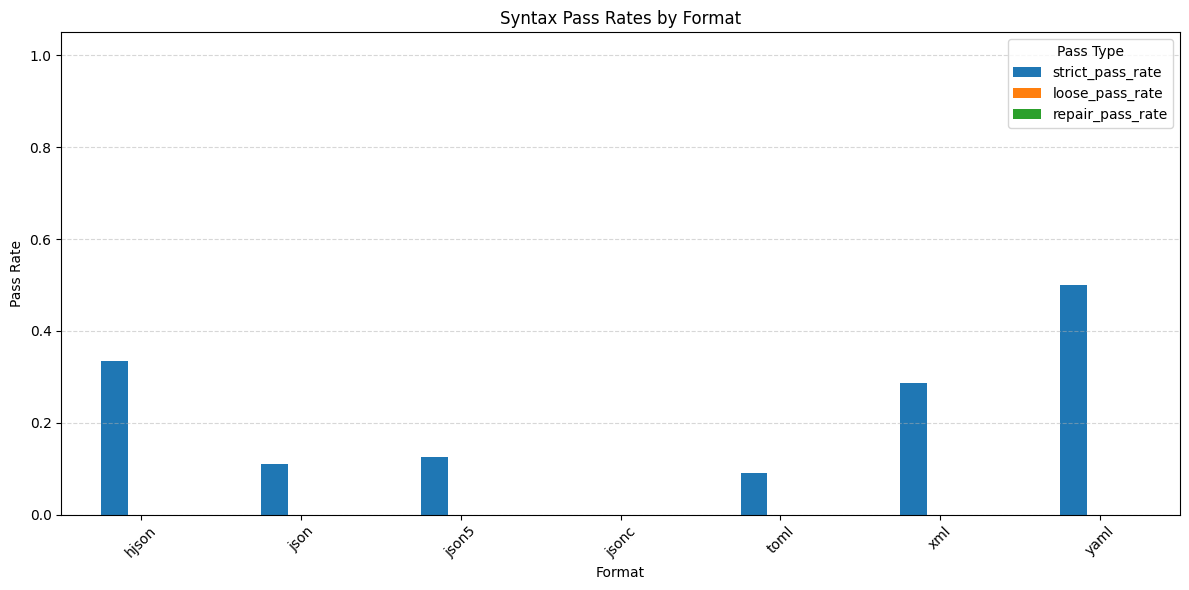

In [3]:
# 可视化语法通过率
plot_syntax_pass_rates(summary_df)

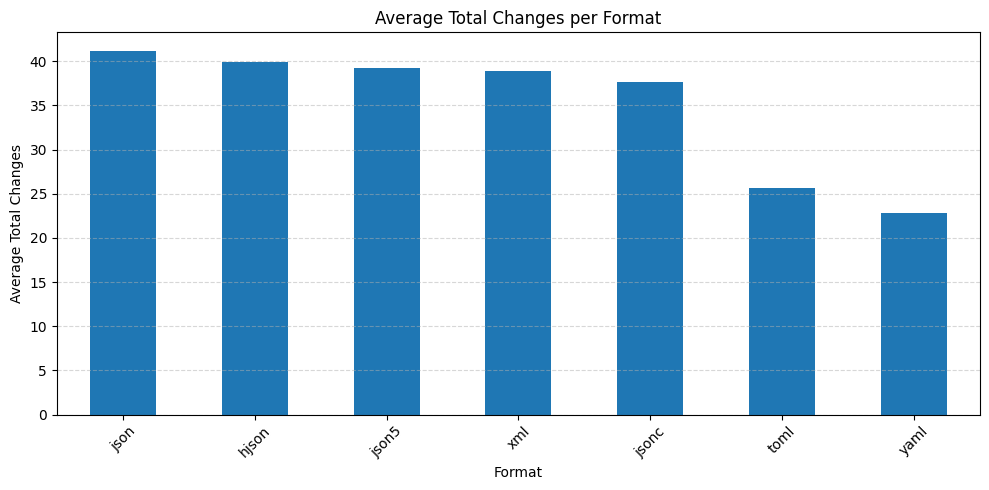

,participantId,format,task,syntax_valid,num_added_lines,num_removed_lines,total_changes,diff_text
0,6697c8b6d9d7baa7edd8c4d3,hjson,writing-task-tabular-hjson,1,21,24,45,diff --git a/var/folders/hs/htjkkv116fv94g1llc...
1,67e25388d573ec2d5f1c8442,yaml,writing-task-tabular-yaml,0,16,12,28,diff --git a/var/folders/hs/htjkkv116fv94g1llc...
2,67e5cf90b79d0874e1cf16b0,toml,writing-task-tabular-toml,1,13,13,26,diff --git a/var/folders/hs/htjkkv116fv94g1llc...
3,67d00f24466a67ba7e41228e,toml,writing-task-tabular-toml,0,10,18,28,diff --git a/var/folders/hs/htjkkv116fv94g1llc...
4,66475d6f7b27e4443ef0d031,json,writing-task-tabular-json,0,14,24,38,diff --git a/var/folders/hs/htjkkv116fv94g1llc...
...,...,...,...,...,...,...,...,...
62,67ab650c320eccf6141d4010,jsonc,writing-task-tabular-jsonc,0,10,27,37,diff --git a/var/folders/hs/htjkkv116fv94g1llc...
63,65fad673a546ab14baf2f8d3,json5,writing-task-tabular-json5,0,13,21,34,diff --git a/var/folders/hs/htjkkv116fv94g1llc...
64,67f1c7bd6f1c4a3d8deae02f,toml,writing-task-tabular-toml,0,7,19,26,diff --git a/var/folders/hs/htjkkv116fv94g1llc...
65,67adb27bd5f5776fcb16da62,hjson,writing-task-tabular-hjson,0,11,25,36,diff --git a/var/folders/hs/htjkkv116fv94g1llc...


In [4]:

# —————————————————————————————————————————————
# 5. 方法三：git-diff 差异统计
# —————————————————————————————————————————————
# 准备你的标准答案 dict
correct_tabular_data = {
  "patients": [
    {"name":"John","tests":[{"id":1,"result":"Normal"},{"id":2,"result":"Elevated Cholesterol"}]},
    {"name":"Michael","tests":[{"id":1,"result":"Normal"}],"treatment":"Regular Monitoring"}
  ]
}


df_diff = analyze_tabular_writing_diff(all_data, correct_tabular_data)
plot_avg_total_changes_by_format(df_diff)
df_diff

## tree dif

/opt/anaconda3/lib/python3.8/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


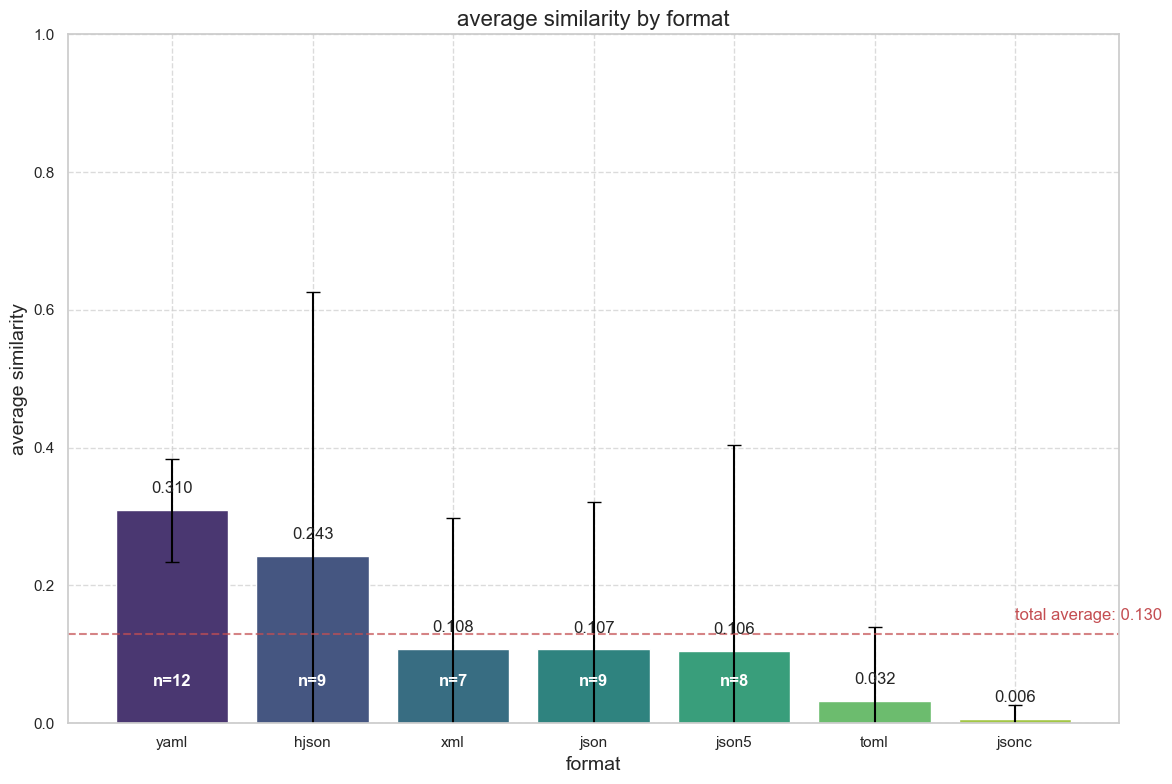

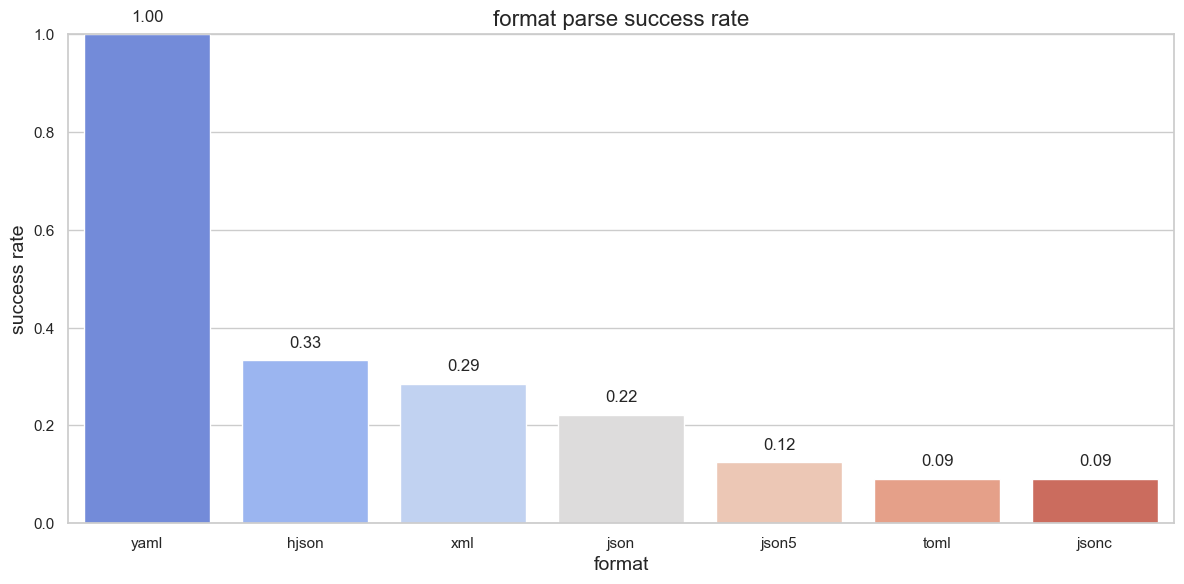

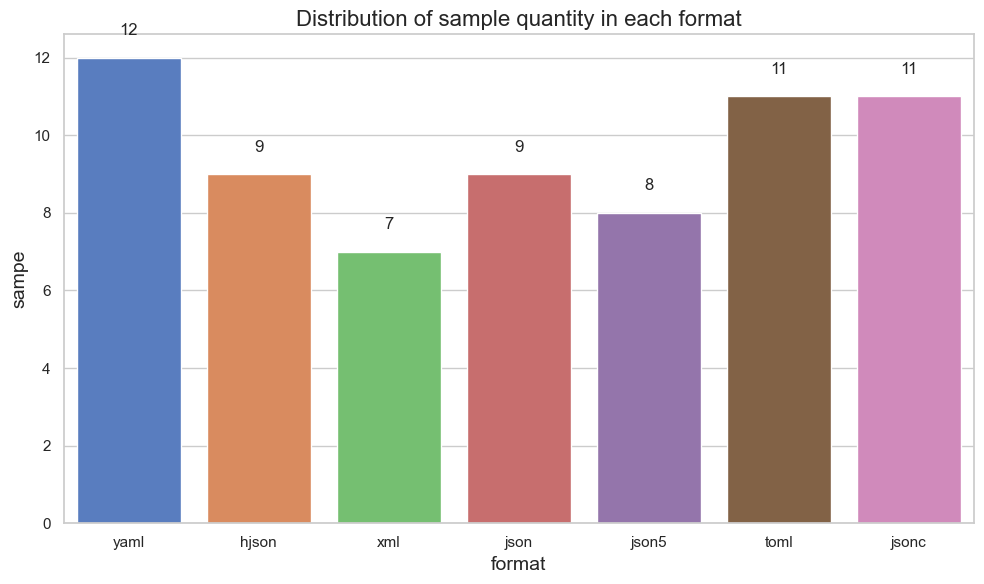

,similarity_score_mean,similarity_score_std,similarity_score_count,similarity_score_min,similarity_score_max,normalized_ted_mean,normalized_ted_std,normalized_ted_min,normalized_ted_max,error_<lambda>,success_rate
format,,,,,,,,,,,
yaml,0.309558,0.074746,12,0.1574,0.4222,0.686433,0.117044,0.5704,0.9852,0,1.000000
hjson,0.242833,0.383573,9,0.0000,1.0000,0.824300,0.328301,0.2148,1.0000,6,0.333333
xml,0.108314,0.190289,7,0.0000,0.4564,0.869057,0.240783,0.3871,1.0000,5,0.285714
json,0.107200,0.214350,9,0.0000,0.5352,0.888889,0.223271,0.4296,1.0000,7,0.222222
json5,0.105550,0.298540,8,0.0000,0.8444,0.897225,0.290692,0.1778,1.0000,7,0.125000
toml,0.032418,0.107519,11,0.0000,0.3566,0.962427,0.124615,0.5867,1.0000,10,0.090909
jsonc,0.006064,0.020111,11,0.0000,0.0667,0.993936,0.020111,0.9333,1.0000,10,0.090909


In [2]:
from linter import batch_tree_distance_analysis_tree_only,visualize_format_similarity,calculate_format_similarity_stats
correct_tabular_data = {
  "patients": [
    {"name": "John", "tests": [{"id": 1, "result": "Normal"}, {"id": 2, "result": "Elevated Cholesterol"}]},
    {"name": "Michael", "tests": [{"id": 1, "result": "Normal"}], "treatment": "Regular Monitoring"}
  ]
}

# 调用函数（传入你的 all_data 和标准答案对象）
df_ted = batch_tree_distance_analysis_tree_only(all_data, correct_tabular_data)

# 你的 ground truth 数据（结构化 JSON 对象）
df_stats=calculate_format_similarity_stats(df_ted)
visualize_format_similarity(df_stats)
df_stats

In [4]:
df_ted[df_ted['format'] == 'yaml'].head(10)

,participantId,format,task,ted,normalized_ted,similarity_score,gold_tree_size,user_tree_size,error
1,67e25388d573ec2d5f1c8442,yaml,writing-task-tabular-yaml,111.0,0.8222,0.1778,135.0,34.0,None
14,67dc19c31078d1581e39e75a,yaml,writing-task-tabular-yaml,77.0,0.5704,0.3648,135.0,101.0,None
18,67adb520391eb17f214a50b4,yaml,writing-task-tabular-yaml,93.0,0.6889,0.3056,135.0,61.0,None
21,66049694dfb8828a8f3dce70,yaml,writing-task-tabular-yaml,93.0,0.6889,0.3111,135.0,57.0,None
31,60fce3df91350150e2e88423,yaml,writing-task-tabular-yaml,78.0,0.5778,0.4222,135.0,101.0,None
32,67d29234dbfdb6668d124115,yaml,writing-task-tabular-yaml,93.0,0.6889,0.3111,135.0,57.0,None
39,637d8ca00150ac6e71a34ec9,yaml,writing-task-tabular-yaml,78.0,0.5778,0.3611,135.0,79.0,None
43,67f3619e16d4ca195fbd1bd0,yaml,writing-task-tabular-yaml,95.0,0.7037,0.2963,135.0,67.0,None
44,67d1283c8f6169900d0072d2,yaml,writing-task-tabular-yaml,133.0,0.9852,0.1574,135.0,5.0,None
52,67f913a9b5c79e960807c7e3,yaml,writing-task-tabular-yaml,88.0,0.6519,0.3481,135.0,78.0,None


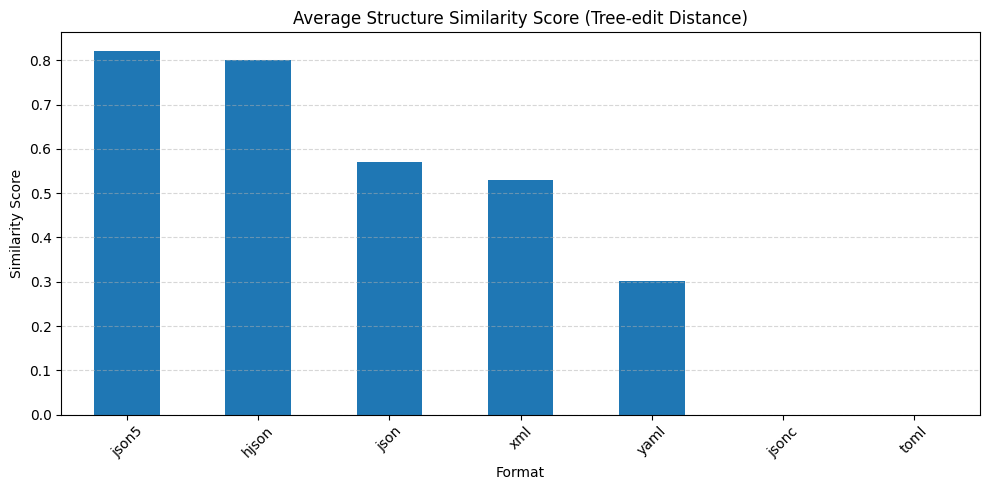

In [5]:
df_ted = batch_tree_distance_analysis(all_data, correct_tabular_data)
plot_similarity_score_by_format(df_ted)
